In [23]:
!pip install roboflow
#data link> https://universe.roboflow.com/roboflow-universe-projects/fire-and-smoke-segmentation/dataset/6

from roboflow import Roboflow
rf = Roboflow(api_key="4sGvq8dK2YQqFiADuN0Z") #secret key
project = rf.workspace("roboflow-universe-projects").project("fire-and-smoke-segmentation")
version = project.version(6)
dataset = version.download("coco-segmentation")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 117.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fire-and-Smoke-Segmentation-6 in coco-segmentation:: 100%|██████████| 7118/7118 [00:01<00:00, 4838.42it/s]


In [1]:
!python -m pip install pyyaml==5.1 #pyYAMl for configuratio and detectron 2 requires <= 5.1 version
import sys #access to python runtime environment
import os #file and  directory operations
import distutils.core  #used to build and install python modules from setup.py


!git clone 'https://github.com/facebookresearch/detectron2' #clones into current directory


dist = distutils.core.run_setup("./detectron2/setup.py") #programmtically runs the setup.py script inside the cloned folder

!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
#install all the dependencies under install requires from the setip.py

sys.path.insert(0, os.path.abspath('./detectron2'))
#adds the absolute path of ./detectron2 to the beginning of sys path

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
#register the dataset

from detectron2.data.datasets import register_coco_instances
register_coco_instances("exp_train", {}, "/content/Fire-and-Smoke-Segmentation-6/train/_annotations.coco.json", "/content/Fire-and-Smoke-Segmentation-6/train")
register_coco_instances("exp_val", {}, "/content/Fire-and-Smoke-Segmentation-6/valid/_annotations.coco.json", "/content/Fire-and-Smoke-Segmentation-6/valid")
register_coco_instances("exp_test", {}, "/content/Fire-and-Smoke-Segmentation-6/test/_annotations.coco.json", "/content/Fire-and-Smoke-Segmentation-6/test")


WARNING [10/01 16:49:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/01 16:49:29 d2.data.datasets.coco]: Loaded 7050 images in COCO format from /content/Fire-and-Smoke-Segmentation-6/train/_annotations.coco.json


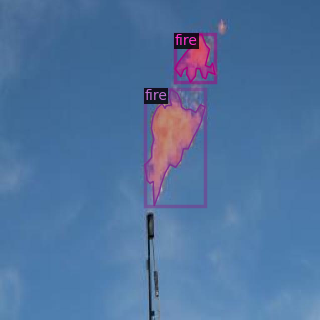

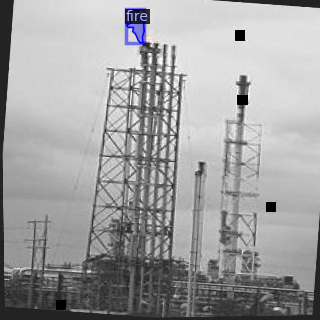

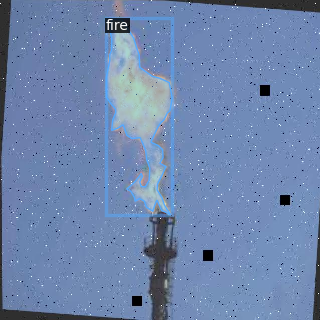

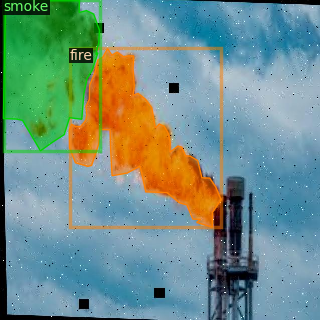

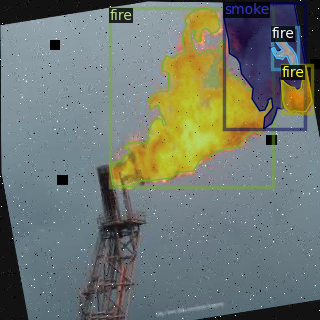

In [4]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("exp_train")
dataset_dicts = DatasetCatalog.get("exp_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [5]:
from detectron2.engine import DefaultTrainer


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("exp_train",)
cfg.DATASETS.TEST = ("exp_val",)  # optional for evaluation during training
cfg.DATALOADER.NUM_WORKERS = 2


cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")


cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0005  # conservative LR for stability
cfg.SOLVER.MAX_ITER = 100   # adjust higher for practical training

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # ensure matches your dataset

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[10/01 16:49:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:01, 247MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[10/01 16:49:52 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/01 16:50:05 d2.utils.events]:  eta: 0:00:37  iter: 19  total_loss: 2.659  loss_cls: 1.264  loss_box_reg: 0.6413  loss_mask: 0.6872  loss_rpn_cls: 0.1175  loss_rpn_loc: 0.0268    time: 0.4783  last_time: 0.4910  data_time: 0.0148  last_data_time: 0.0064   lr: 9.5405e-05  max_mem: 2493M
[10/01 16:50:18 d2.utils.events]:  eta: 0:00:26  iter: 39  total_loss: 1.985  loss_cls: 0.625  loss_box_reg: 0.7279  loss_mask: 0.5996  loss_rpn_cls: 0.0485  loss_rpn_loc: 0.01883    time: 0.4574  last_time: 0.3610  data_time: 0.0062  last_data_time: 0.0057   lr: 0.00019531  max_mem: 2653M
[10/01 16:50:27 d2.utils.events]:  eta: 0:00:17  iter: 59  total_loss: 1.746  loss_cls: 0.4538  loss_box_reg: 0.7399  loss_mask: 0.508  loss_rpn_cls: 0.02192  loss_rpn_loc: 0.009879    time: 0.4554  last_time: 0.4355  data_time: 0.0058  last_data_time: 0.0054   lr: 0.0002952  max_mem: 2653M
[10/01 16:50:37 d2.utils.events]:  eta: 0:00:08  iter: 79  total_loss: 1.72  loss_cls: 0.3851  loss_box_reg: 0.8063  loss_mask:

In [6]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("exp_test", )
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("exp_test")


[10/01 16:50:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [10/01 16:50:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/01 16:50:50 d2.data.datasets.coco]: Loaded 20 images in COCO format from /content/Fire-and-Smoke-Segmentation-6/test/_annotations.coco.json


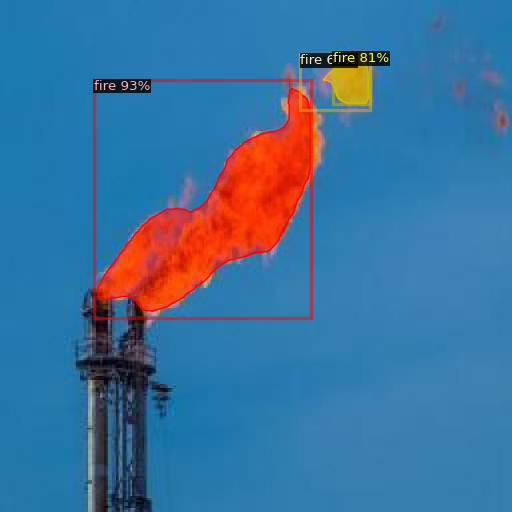

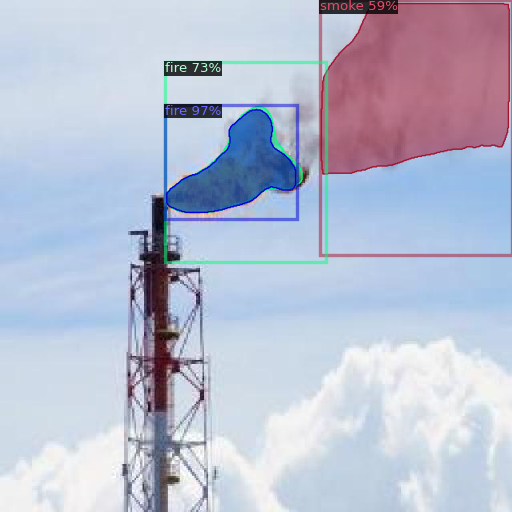

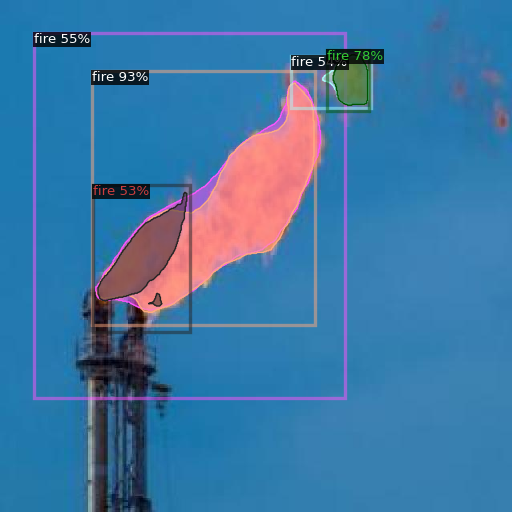

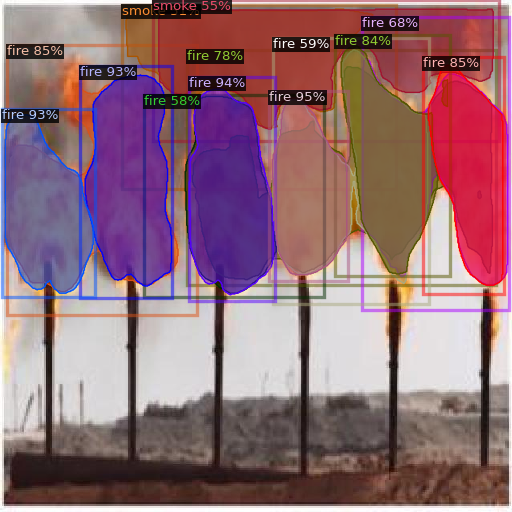

In [7]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_train_metadata, # Use the correct metadata variable
                   scale=0.8,
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])